# Bayesian Hierarchical Modeling: A Chocolate Cookies Example.

<img src="https://steemitimages.com/p/2ufhwNgM3qHKRHbpAEf6aiBzphYwwauCfseKgB7U9CEDPt5HEQLHMoTyGeJJTzTfAuV3EStZ4?format=match&mode=fit" alt="html" style="width: 400px;"/>


Source: https://juanitorduz.github.io/intro_pymc3/

Now we are going to treat an example which illustrated a hierarchical model.



## The data

Assume there is a big factory producing chocolate cookies around the world. The cookies follow a unique recipe, but you want to study the chocolate chips distribution for cookies produced in 5 different locations.

- On the one hand side you would assume that the distribution across the locations is similar, as they all come from a unique recipe. This is why you may not want to model each location separately. 

- On the other hand, in reality, as the locations are not exacly the same you might expect some differences between each location.  This is why you may not want to model all locations at once.

To overcome these restrictions, a hierarchical can be a feasible approach.  


Data: https://d3c33hcgiwev3.cloudfront.net/_25ad8f0154906d5d83efc640647beb4b_cookies.dat?Expires=1572566400&Signature=C3eoNdqLJVOg3KGVHfgZrL-zxTE8PMRAFZasISl99tFaIxlZOfVtriBV9JaVyrEY1sZ9xcU1J5vVt9yd6FUUlqTvQ-rBFe7u7Ru3v4Ftk402ioPzvsj6-wGxnxumtHDqpoAJC3uP3J1fLbXzjCBmJW6Ks9mDnHclGRh6xcejyP8_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A

We begin reading the data into a pandas dataframe.

In [8]:
import pandas as pd
import pymc3 as pm
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt
%matplotlib inline


In [9]:

# We begin reading the data into a pandas dataframe.
cookies = pd.read_csv('data/cookies.dat', sep = ' ')

cookies.head()

,chips,location
0,12,1
1,12,1
2,6,1
3,13,1
4,12,1


Please verify the number of locations!

In [10]:
# Let us verify the number of locations.
cookies.location.unique()

array([1, 2, 3, 4, 5])

We can do some visualization of the data to know:

- How is the distribution of chocolate chips for all cookies?
- How about distribution of chocolate chips for cookies in each location?


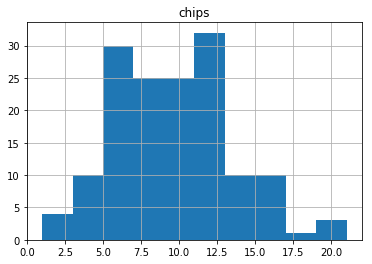

In [11]:
# Histogram distribution of chocolate chips
# for all cookies.
cookies.hist(column='chips', bins=10);

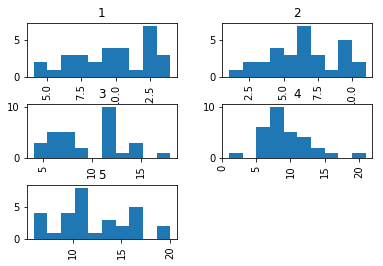

In [12]:
# Histogram distribution of chocolate chips
# for cookies in each location.
cookies.hist(column='chips', by='location', bins=10);

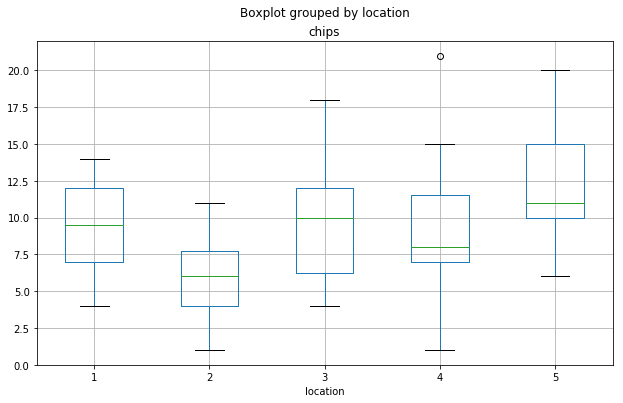

In [13]:
# Box plot for different locations.
cookies.boxplot(column='chips', by='location', figsize=(10,6));

## The model: Hierarchical Approach


- Hierarchical Model:

We model the chocolate chip counts by a Poisson distribution with parameter \\(\lambda\\). We choose a gamma prior.

\begin{align}
chips \sim  Poiss(\lambda)
\quad\quad\quad
\lambda \sim  \Gamma(a,b)
\end{align}

- Parametrization:

We parametrize the shape and scale of the gamma prior with the mean \\(\mu\\) and variance \\(\sigma^2\\).

\begin{align}
a=\frac{\mu^2}{\sigma^2}
\quad\quad\quad
b=\frac{\mu}{\sigma^2}
\end{align}

- Prior Distributions:

We further impose prior for these parameters

\begin{align}
\mu  \sim  \Gamma(2,1/5)
\quad\quad\quad
\sigma  \sim  Exp(1)
\end{align}





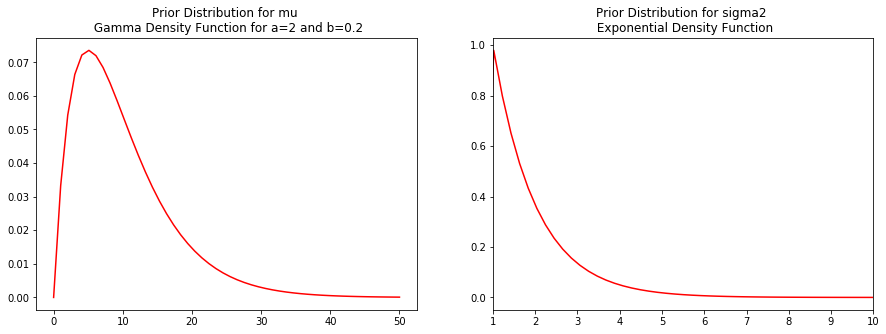

In [14]:
x = np.linspace(0,50)

fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(x, ss.gamma.pdf(x,a=2,scale=5), 'r-')
plt.title('Prior Distribution for mu \n Gamma Density Function for a={} and b={}'.format(2,1/5))

plt.subplot(1, 2, 2)
x = np.linspace(0,10)
plt.plot(x, ss.expon.pdf(x,1), 'r-')
plt.title('Prior Distribution for sigma2 \n Exponential Density Function')
plt.xlim(1,10)


plt.show()

Let us write the model in PyMC3. Note how the syntax mimics the mathematical formulation.

In [15]:
model = pm.Model()

with model:
    
    # Prior distribution for mu.
    mu = pm.Gamma('mu', alpha=2.0, beta=1.0/5)
    
    # Prior distribution for sigma2.
    sigma = pm.Exponential('sigma', 1.0)
    
    # Parametrization for the shape parameter.
    alpha =  mu**2/sigma**2
    
    # Parametrization for the scale parameter.
    beta = mu/sigma**2
    
    # Prior distribution for lambda.
    lam = pm.Gamma('lam', alpha=alpha, beta=beta, 
                   shape=cookies.location.values.max())
    
    # Likelihood function for the data.
    chips = [pm.Poisson('chips_{}'.format(i),lam[i], 
            observed=cookies[cookies.location==i+1].chips.values) 
            for i in range(cookies.location.values.max())] 
    
    
    # Parameters of the simulation:
    # Number of iterations and independent chains.
    n_draws, n_chains = 1000, 3
    
    n_sim = n_draws*n_chains
    
    trace = pm.sample(draws=n_draws, chains=n_chains)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [lam, sigma, mu]
Sampling 3 chains: 100%|██████████| 4500/4500 [00:02<00:00, 1661.38draws/s]


## Diagnostics

Many [diagnostic](https://pymc-devs.github.io/pymc3/api/diagnostics.html) options are described in the PyMC3 documentation. 

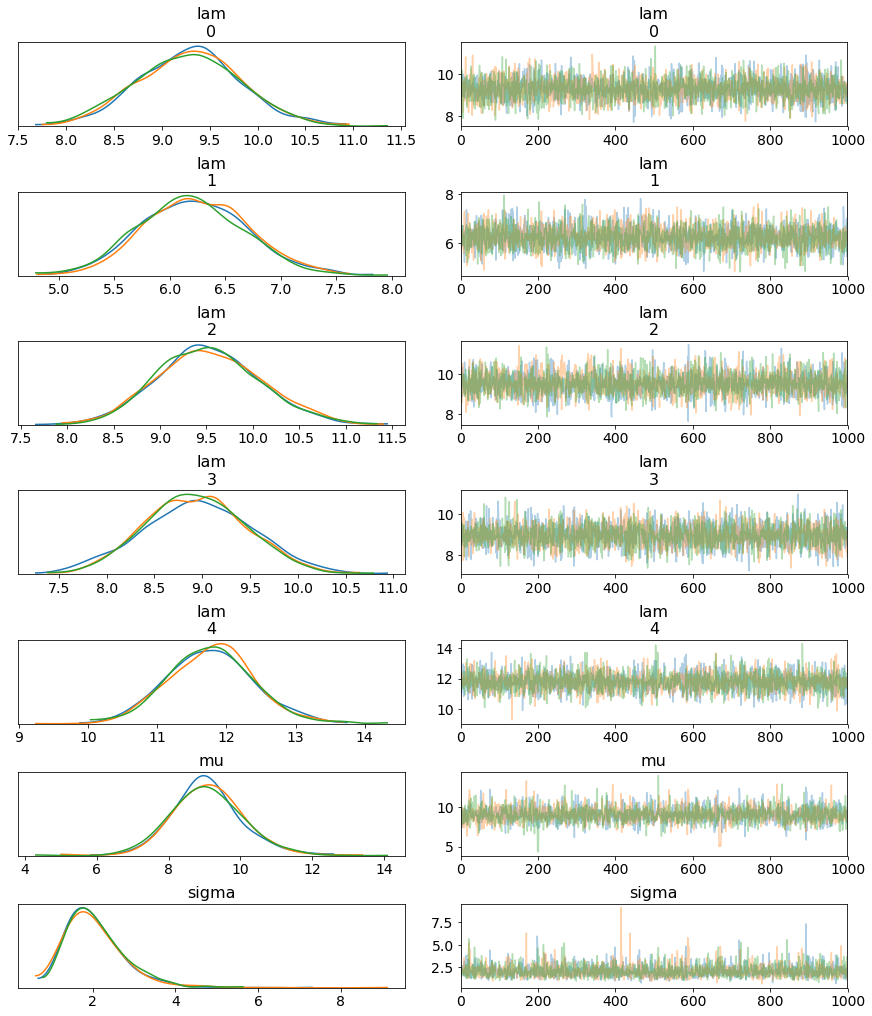

In [16]:
pm.traceplot(trace);

From the traceplot we see that the chains have converged. We can also have a detailed summary of the posterior distribution for each parameter:

In [17]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,9.089339,1.004143,0.019810,7.143976,11.079324,2375.966887,0.999947
sigma,2.071499,0.715013,0.013074,1.015244,3.460907,2866.810109,1.000420
lam__0,9.288108,0.537747,0.009045,8.189978,10.305530,3965.274340,0.999913
lam__1,6.222832,0.471968,0.007597,5.328668,7.163258,3515.748834,1.002166
lam__2,9.529859,0.554208,0.009868,8.577551,10.739911,3703.498556,0.999725
lam__3,8.947479,0.548132,0.007661,7.904230,10.044864,3982.367018,0.999715
lam__4,11.775526,0.617005,0.010787,10.560452,12.984633,3171.098972,0.999640


We can also see this visually.

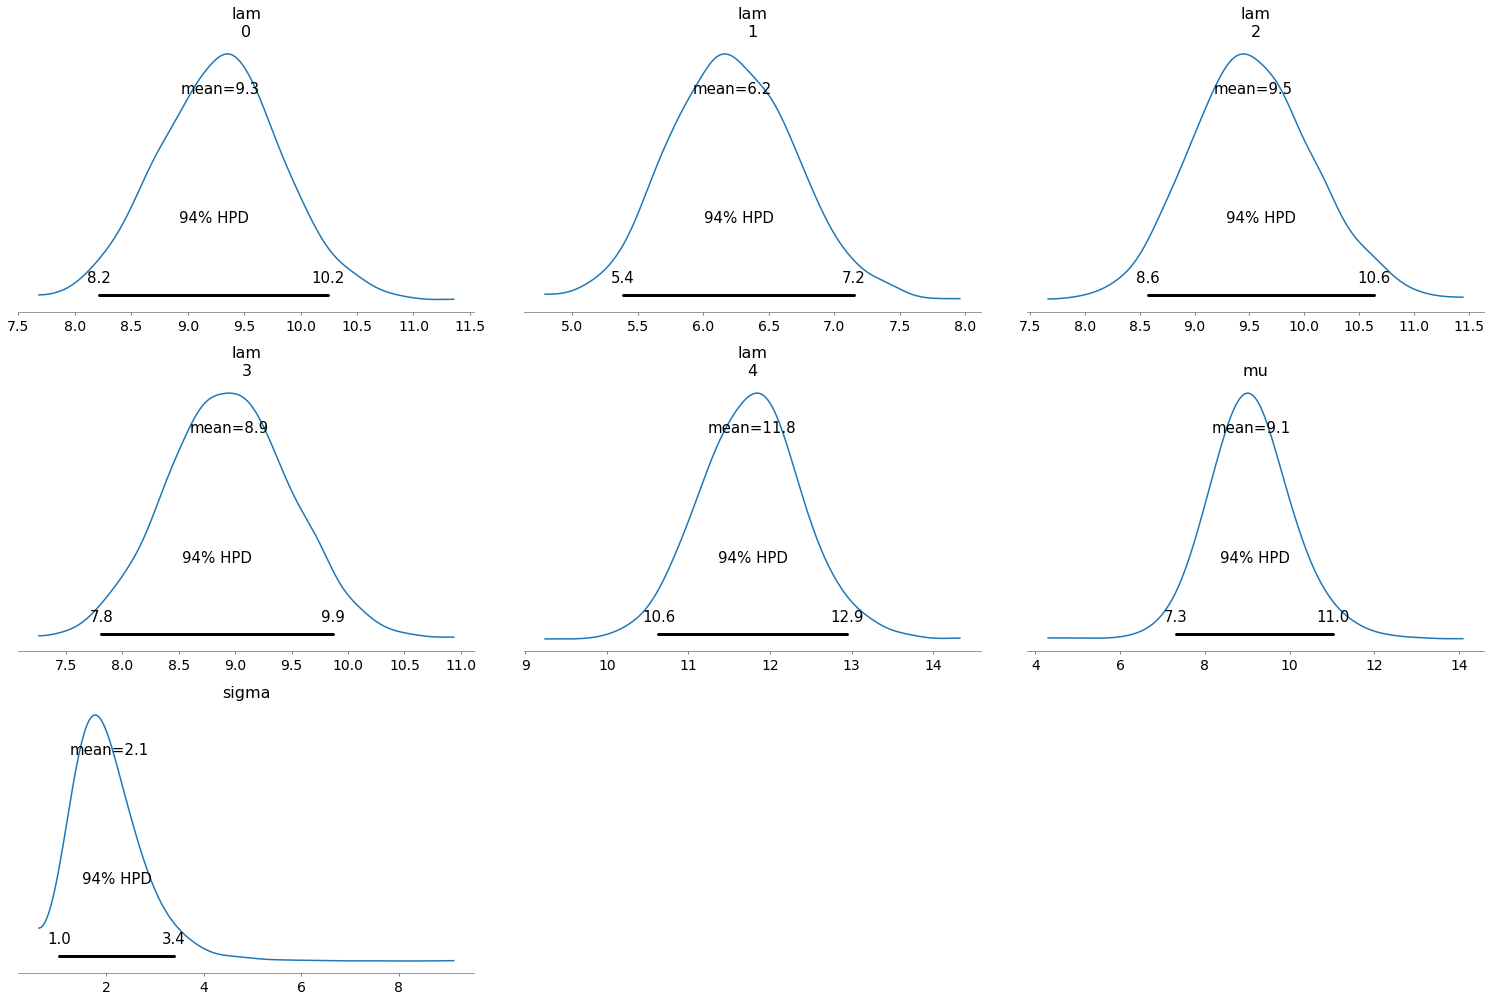

In [18]:
pm.plot_posterior(trace);

We can verify the convergence of the chains formally using the Gelman Rubin test. Values close to 1.0 mean convergence. 

In [19]:
pm.gelman_rubin(trace)

{'lam': array([0.99991272, 1.00216601, 0.9997247 , 0.99971493, 0.9996396 ]),
 'mu': 0.9999471700820428,
 'sigma': 1.0004196299492056}

We can also test for correlation between samples in the chains. We are aiming for zero auto-correlation to get "random" samples from the posterior distribution.

/home/nasalsabila/anaconda3/envs/airy/lib/python3.5/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


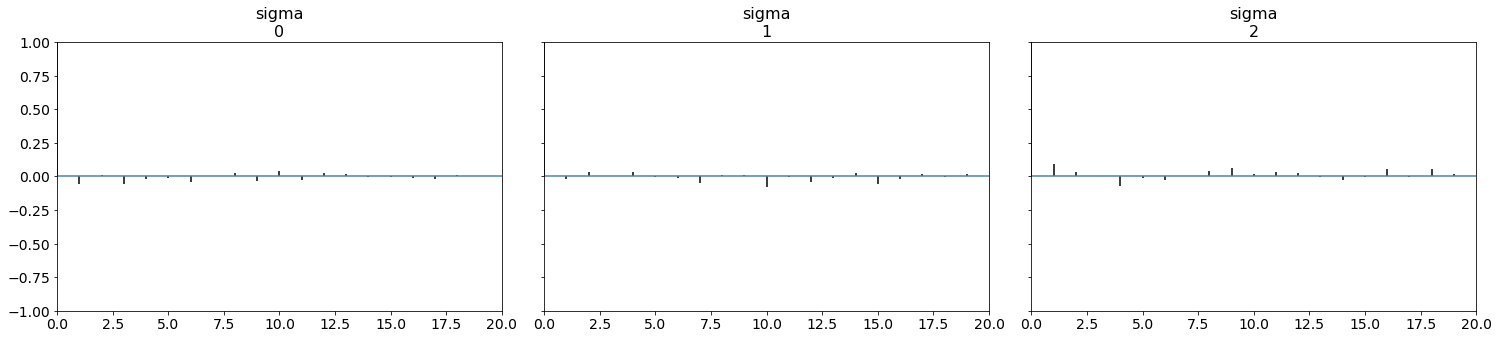

In [20]:
# Auto-correlation of the parameter sigma for the 3 chains.
pm.autocorrplot(trace, varnames=['sigma'], max_lag=20);

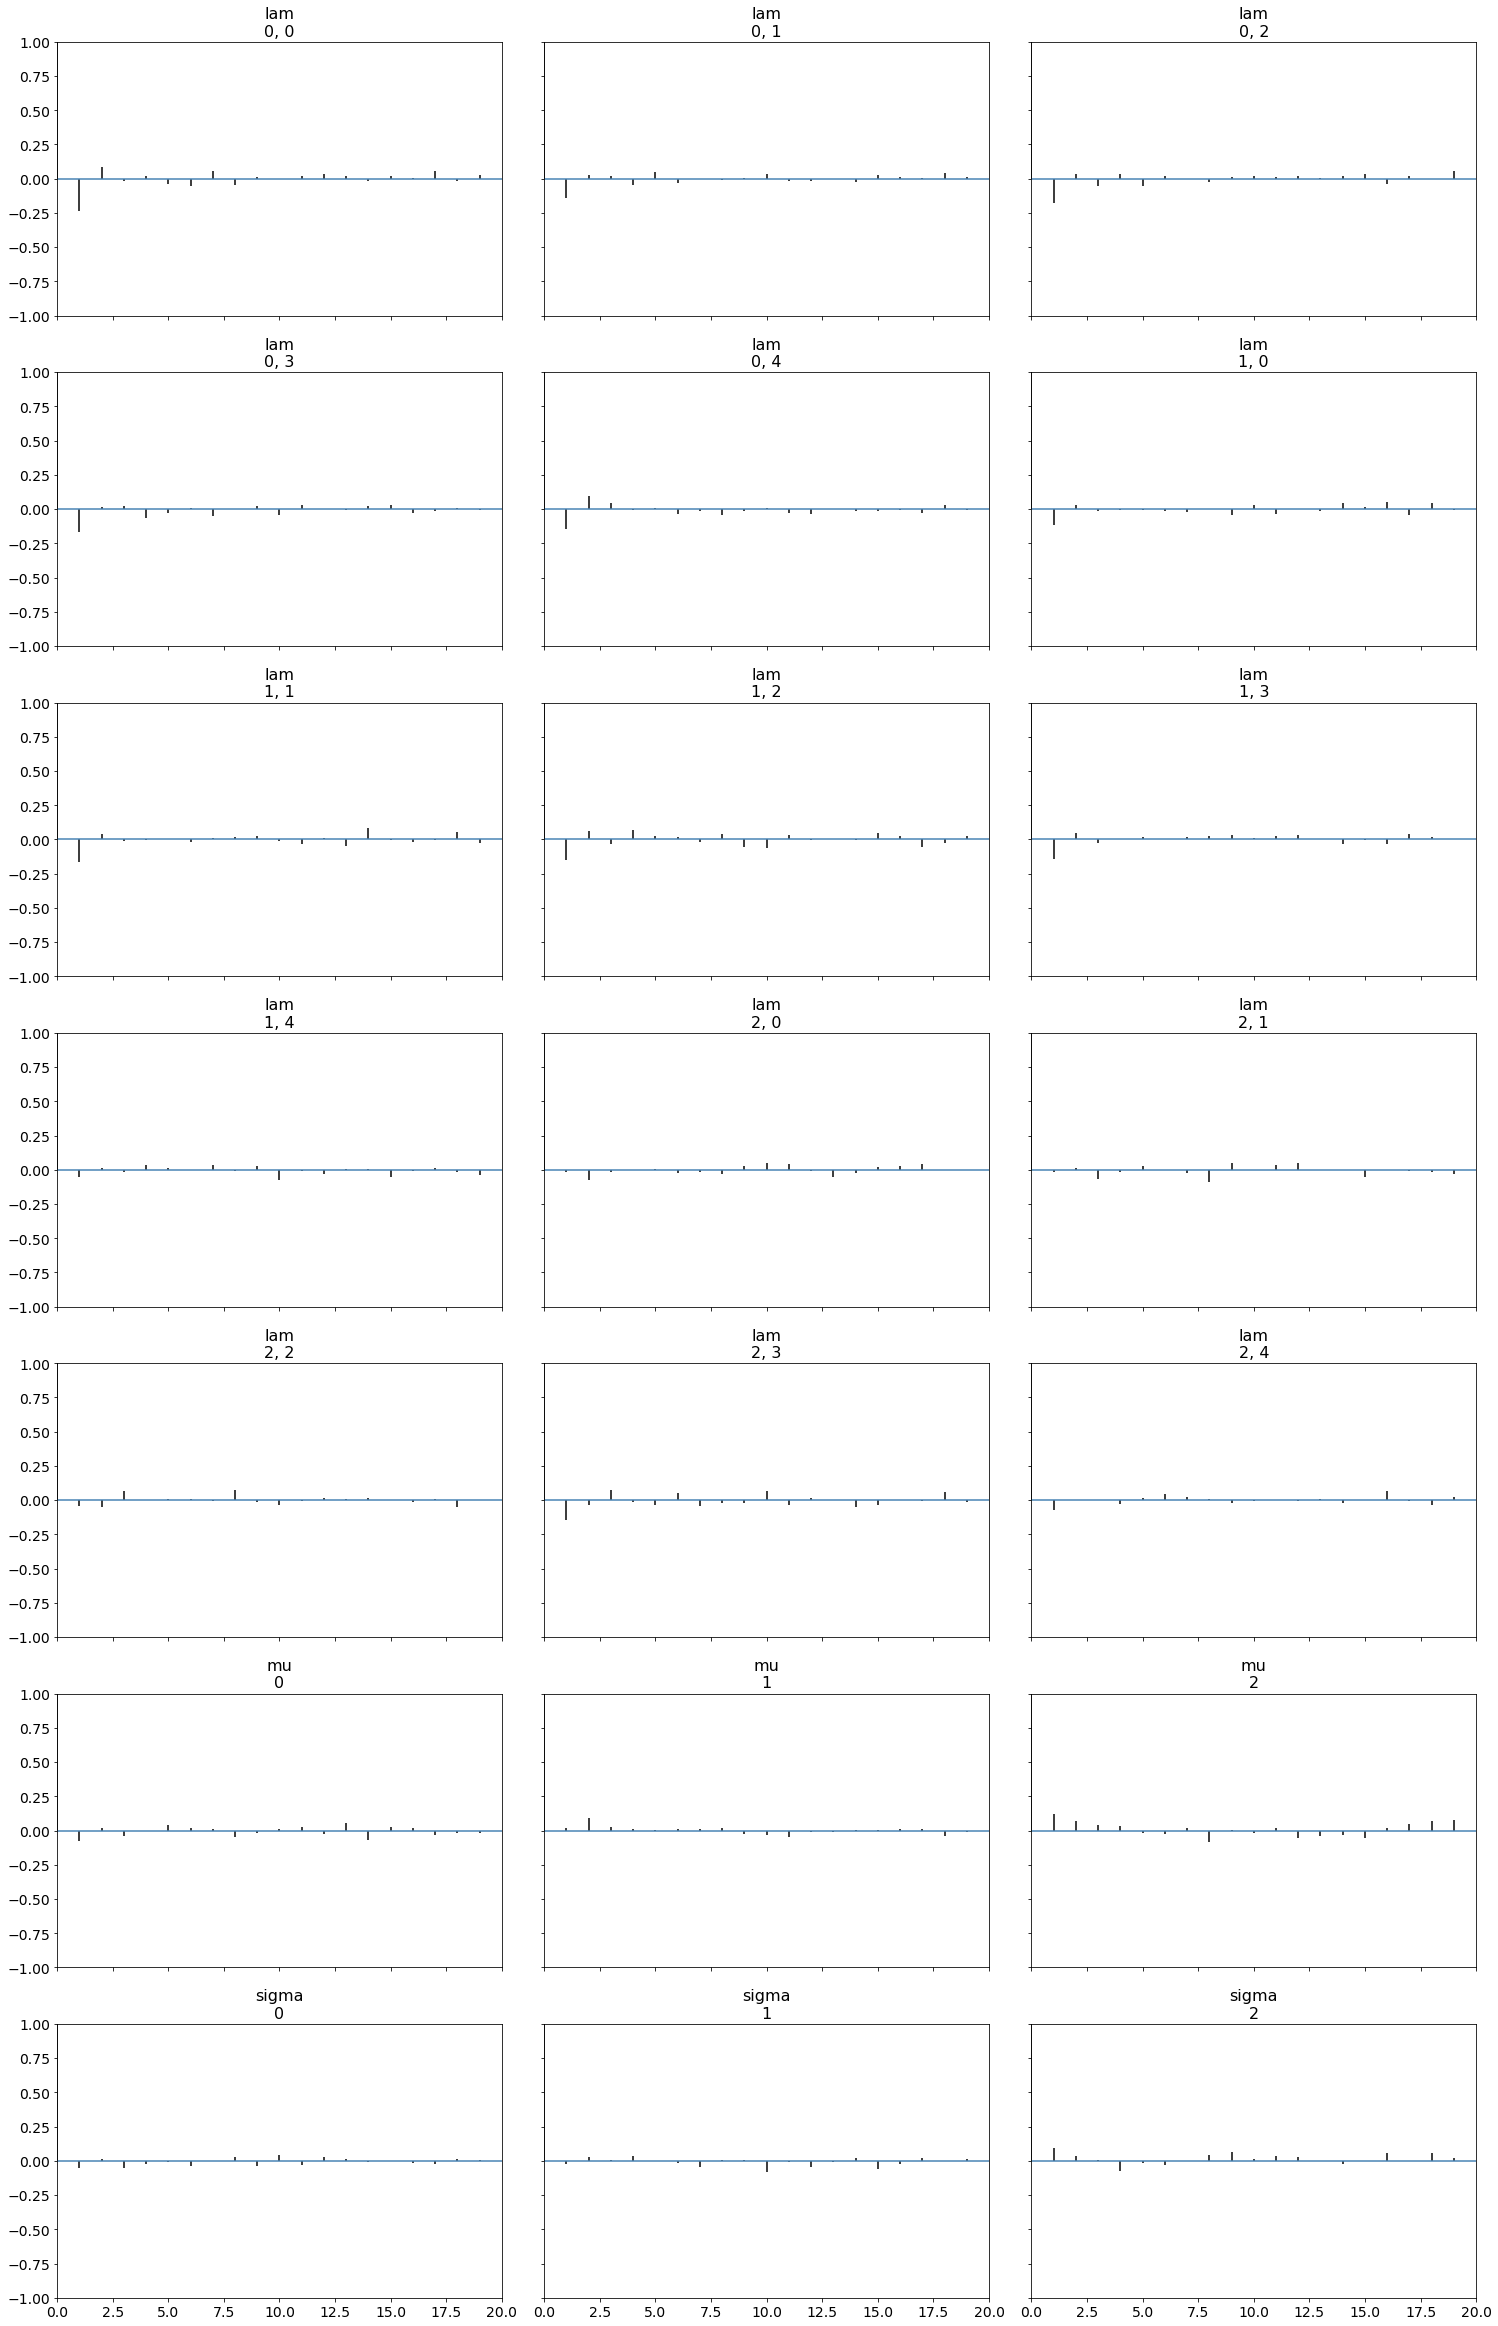

In [21]:
# We can also consider all the variables simultaneously. 
pm.autocorrplot(trace, max_lag=20);

From these plots we see that the auto-correlation is not problematic. Indeed, we can test this through the *effective sample size*, which sould be close to the total sumber of samples `n_sim`.

In [22]:
pm.diagnostics.effective_n(trace)

{'lam': array([3965.27433982, 3515.74883436, 3703.49855586, 3982.36701848,
        3171.09897209]), 'mu': 2375.9668869115835, 'sigma': 2866.8101085739922}

Finally, we can compute the [Widely-applicable Information Criterion (WAIC)](https://en.wikipedia.org/wiki/Watanabe%E2%80%93Akaike_information_criterion).

In [23]:
hierarchical_waic = pm.waic(trace, model=model)
hierarchical_waic.WAIC

/home/nasalsabila/anaconda3/envs/airy/lib/python3.5/site-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/nasalsabila/anaconda3/envs/airy/lib/python3.5/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


789.9625470083076

## Residual analysis

In order to evaluate the model results we analyze the behaviour of the residuals.

In [24]:
# Compute the mean of the simulation.
lambda_mean = np.apply_along_axis(np.mean, 0, trace['lam'])

# Compute for each sample the posterior mean.
cookies['yhat'] = cookies.location.apply(lambda x: lambda_mean[x-1])

# Compute the residuals.
cookies['resid'] = cookies.apply(lambda x: x.chips - x.yhat, axis=1)

cookies.head()

,chips,location,yhat,resid
0,12,1,9.288108,2.711892
1,12,1,9.288108,2.711892
2,6,1,9.288108,-3.288108
3,13,1,9.288108,3.711892
4,12,1,9.288108,2.711892


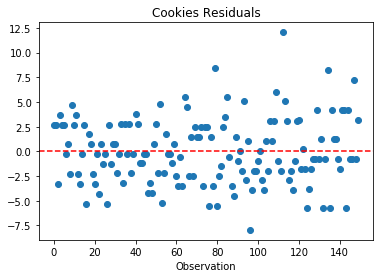

In [25]:
# Cookies Residuals
plt.scatter(x=cookies.index.values, y=cookies.resid.values)
plt.axhline(y=0.0, color='r', linestyle='--')
plt.title('Cookies Residuals')
plt.xlabel('Observation');

We do not see a particular partern in the scatter plot of the residuals against the observation.

Text(0.5, 1.0, 'Cookies Residuals')

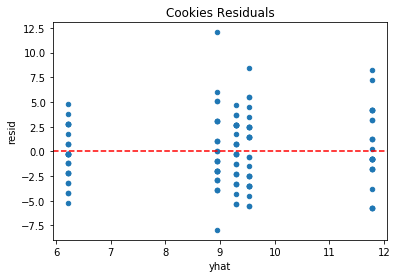

In [26]:
cookies.plot.scatter(x='yhat', y='resid');
plt.axhline(y=0.0, color='r', linestyle='--')
plt.title('Cookies Residuals')

## Predictions

Finally, we are going to illustrate how to use the simulation results to derive predictions.

### For a known location

Let us consider Location 1. We want, for example, to compute the posterior probability the next cookie in this location has less than 7 chips.

0.18033333333333335

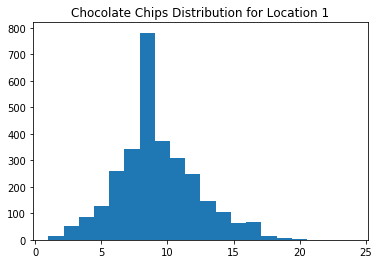

In [27]:
# We generate n_sim samples of a Poisson distribution for 
# each value for lam_0 (location 1) simulation..
y_pred_location_1 = np.random.poisson(lam=trace['lam'][:,0] , size=n_sim)

plt.figure()
plt.hist(y_pred_location_1, bins=20)
plt.title('Chocolate Chips Distribution for Location 1');

# Probability the next cookie in location has less than 7 chips.
(y_pred_location_1<7).astype(int).mean()

### For a new location

Now assume we want to open a new location. First, we want to compute the posterior probability that this new location has \\(\lambda > 15\\).

0.016

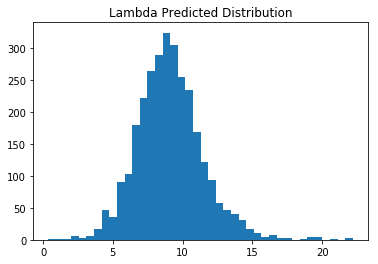

In [28]:
# Posterior distribution of for a an b 
# from the simulated values of mu and sigma2.
post_a = trace['mu']**2/trace['sigma']**2
post_b = trace['mu']/trace['sigma']**2

# We now generate samples of a gamma distribution 
# with these generated parameters of a and b.
lambda_pred_dist = np.random.gamma(post_a,1/post_b,n_sim) 

plt.figure()
plt.hist(lambda_pred_dist, bins=40)
plt.title('Lambda Predicted Distribution');

# Posterior probability a new location has lambda > 15.
(lambda_pred_dist>15).astype(int).mean()

Now we answer a question at the next level of the hierarchical model. We want to calculate the posterior probability for a cookie produced in a new location to have more than 15 chocolate chips.

0.058

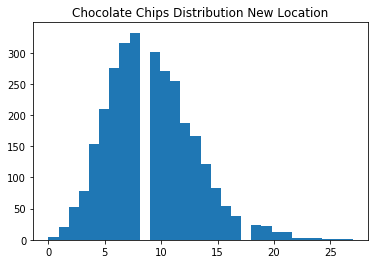

In [29]:
# Posterior distribution of the chips.
# Here we use the values of lambda obtained above.
cookies_pred_dist = np.random.poisson(lam=lambda_pred_dist, size=n_sim)

plt.figure()
plt.hist(cookies_pred_dist, bins=30)
plt.title('Chocolate Chips Distribution New Location');

# Posterior probability that a cookie produced 
# in a new location has more than 15 chocolate chips.
(cookies_pred_dist>15).astype(int).mean()

# References and Further Reading

## Bayesian Probability


- [Coursera: Bayesian Statistics: From Concept to Data Analysis](https://www.coursera.org/learn/bayesian-statistics)

- [Coursera: Bayesian Statistics: Techniques and Models](https://www.coursera.org/learn/mcmc-bayesian-statistics)

- [A First Course in Bayesian Statistical Methods, Peter D. Hoff](http://www.springer.com/us/book/9780387922997)

- [An Introduction to Bayesian Analysis: Theory and Methods, Ghosh, Jayanta K., Delampady, Mohan, Samanta, Tapas](http://www.springer.com/la/book/9780387400846)

## PyMC3

- [Documentation](https://pymc-devs.github.io/pymc3/index.html)

- [Probabilistic Programming in Python using PyMC, John Salvatier, Thomas Wiecki, Christopher Fonnesbeck](https://arxiv.org/abs/1507.08050)